# Pre-floding + Watershed Segmentation

The watershed transform is a popular region growing segmentation technique. Each minima in the image receives a label of different color and the flooding procedure stops when the labels of different colors touch each other.

The major problem of the watershed tranform is that usually images have thousands of minima and since each minimum births a region in the segmentation, this leads to an oversegmentation problem, i.e. too many regions in the final segmentation. This problem is illustrated below. 

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import dicom # library for reading dicom files
import siamxt #max-tree library
import iaws # Watershed library
import time

Image info:
Shape: (256, 252)
Max.: 307
Min.: 0
Data type: uint16


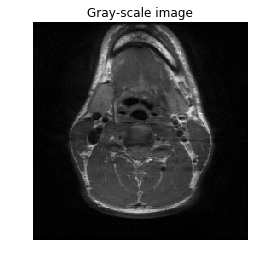

In [2]:
dcm = dicom.read_file("../Figures/carotid.dcm") # Reads dicom file
data = dcm.pixel_array # Gets image array from dicom object

print "Image info:"
print "Shape:",data.shape
print "Max.:",data.max()
print "Min.:", data.min()
print "Data type:", data.dtype

#Display image on the jupyter-notebook
plt.imshow(data,cmap = "gray")
plt.title("Gray-scale image")
plt.axis('off') # Remove axis of the image. ALways use when displaying images
plt.show()

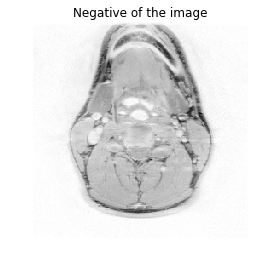

Max-tree info:
Construction time: 0.009727 s
# of nodes: 8786
# of leaves (regional maxima): 4500
Filtered max-tree info:
Construction time: 0.009727 s
# of nodes: 1730
# of leaves (regional maxima): 222


In [3]:
Bc = np.ones((3,3), dtype =bool)
data_max = data.max()
data_neg = data_max - data

#Display image on the jupyter-notebook
plt.imshow(data_neg,cmap = "gray")
plt.title("Negative of the image")
plt.axis('off') # Remove axis of the image. ALways use when displaying images
plt.show()

# Max-tree construction
t = time.time()
mxt = siamxt.MaxTreeAlpha(data_neg,Bc)
t = time.time() - t
print "Max-tree info:"
print "Construction time: %f s" %(t)
print "# of nodes:", mxt.node_array.shape[1]
print "# of leaves (regional maxima):", (mxt.node_array[1,:] == 0).sum()

h = 11
# The area-open will work as the flooding here
mxt.hmax(h)
flooded_img = data_max - mxt.getImage()
print "Filtered max-tree info:"
print "Construction time: %f s" %(t)
print "# of nodes:", mxt.node_array.shape[1]
print "# of leaves (regional maxima):", (mxt.node_array[1,:] == 0).sum()

In [4]:
H,W = data.shape
marker_nodes = np.nonzero(mxt.node_array[1,:] == 0)[0]
seeds = mxt.node_array[4,marker_nodes]
xs = seeds/W
ys = seeds%W

# We will use the minima of the pre-flooded image as markers
marker = np.zeros(data.shape,dtype = np.int32)
labels = np.arange(1,xs.size+1, dtype = np.int32)*10
np.random.shuffle(labels)
marker[xs,ys] = labels

In [5]:
t = time.time()
seg = iaws.ws_markers(flooded_img,marker,Bc)
t = time.time() - t
print "Watershed time: %f s" %(t)

Watershed time: 0.025800 s


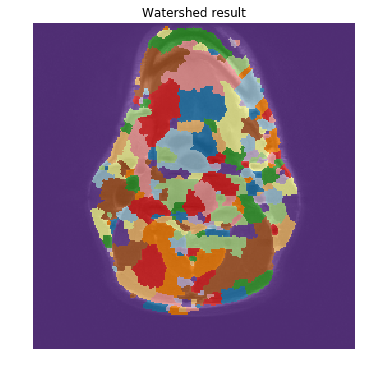

In [6]:
#Display image on the jupyter-notebook
plt.figure(figsize=(12,6))
plt.imshow(data,cmap = "gray")
plt.imshow(seg, cmap='Paired', interpolation='nearest',alpha = 0.75)
plt.title("Watershed result")
plt.axis('off') # Remove axis of the image. ALways use when displaying images
plt.show()

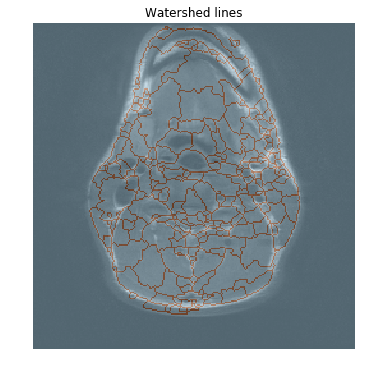

In [7]:
def ws_lines(seg):
   p1 = seg[0:-2,1:-1] > seg[1:-1,1:-1] #x-up
   p2 = seg[2:,1:-1] > seg[1:-1,1:-1] #x-down
   p3 = seg[1:-1,0:-2] > seg[1:-1,1:-1] #y-up
   p4 = seg[1:-1,2:] > seg[1:-1,1:-1] #y-down
   seg2 = np.zeros_like(seg)
   indexes = p1 | p2 | p3 | p4
   seg2[1:-1,1:-1][indexes] = 1#seg[1:-1,1:-1][indexes]
   return seg2

seg_lines = ws_lines(seg)
#Display image on the jupyter-notebook
plt.figure(figsize=(12,6))
plt.imshow(data,cmap = "gray")
plt.imshow(seg_lines, cmap='Paired', interpolation='nearest',alpha = 0.5)
plt.title("Watershed lines")
plt.axis('off') # Remove axis of the image. ALways use when displaying images
plt.show()